In [1]:
#pip install pyproj

In [2]:
#pip install netdcf4
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy.spatial.qhull as qhull
from scipy.interpolate import griddata
import pyproj
from u_interpolate_small import regrid_irregular_quick
#from mpl_toolkits.basemap import Basemap

In [10]:
# read cores daily data
month='06'
#os(ls)
#for i in ls
core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/06/201006081045.nc'
#core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/',month,'/201006081045.nc'
core_data = nc.Dataset(core_filename,'r')
#print(core_data)
#cores_temp = np.array(core_data.variables['cores'])
cores = np.array(core_data.variables['cores'])
#cores = cores.append(cores_temp)
# make a lat x lon x time dataset for monthly cores

#global_attributes = core_data.__dict__

# read precip data
#precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/'
#precip_data = nc.Dataset(precip_filename,'r')

In [11]:
# read in cores lat/lon
lat = np.array(core_data.variables['lat'][:])
lon = np.array(core_data.variables['lon'][:])
#lon[lon<-180] = np.nan
lon_filter = lon >-181 # acceptable values
lon_fl = lon[lon_filter] #filtered long
time = core_data.variables['time'][:]
X, Y = np.meshgrid(lon_fl,lat)
cores_fl=(cores[0,:,0:lon_fl.shape[0]])
#map = Basemap(projection='merc',llcrnrlon=-28,llcrnr#lat=-38.,urcrnrlon=35.,urcrnrlat=25.,resolution='i') # projection, lat/lon extents and resolution of polygons to draw

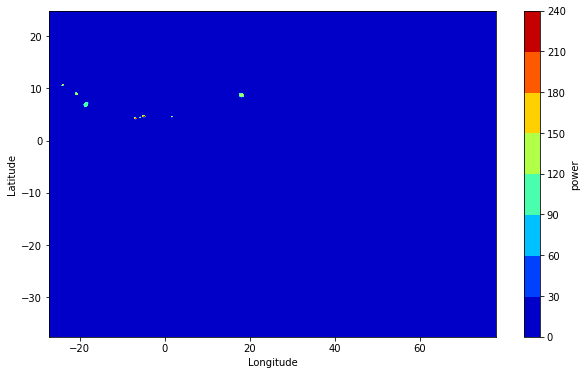

In [16]:
# visualize core data at inherent grid/resol
plt.figure(figsize=(10,6))
plt.contourf(X,Y,cores_fl,cmap='jet')
plt.colorbar(label='power')
#plt.title(cores.time)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
core_data.close()

In [13]:
# replace with precip data grid
new_lat = np.linspace(min(lat),max(lat),2000)#(lat[2]-lat[1])*2)
new_lon = np.linspace(min(lon_fl),max(lon_fl),1900)#(lat[2]-lat[1])*2)
X_new, Y_new = np.meshgrid(new_lon,new_lat)
A = regrid_irregular_quick(lon_fl,lat,new_lon,new_lat,cores_fl)
#print(A.shape)

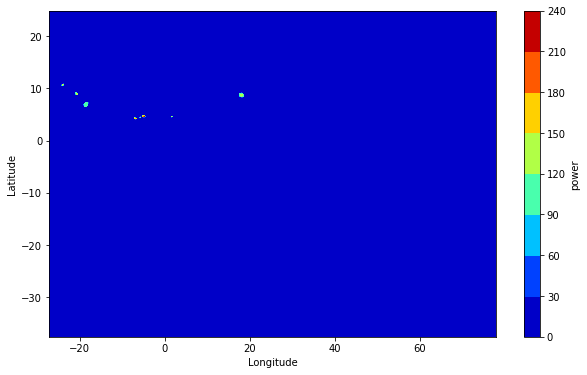

In [14]:
# visualize regridded data
plt.figure(figsize=(10,6))
plt.contourf(X_new,Y_new,A,cmap='jet')
plt.colorbar(label='power')
#plt.title(cores.time)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [15]:
# calculate frequency of rainfall above a threshold 

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [ ]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [ ]:
# calculate fraction of missed rainfall pixels above a threshold

def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [ ]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [ ]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [ ]:
treached = []
tnames = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        dat = strt[kk]
    cc = calc_treshReached(dat,20)
    print(cc, kk)
    treached.append(cc)
    tnames.append(kk)

In [ ]:
tcaught = []
for kk in strt.keys():
    try:
        dat = strt[kk]['rain']
    except:
        continue
    if '3k' in kk:
        ipdb.set_trace()
        precip  = strt['3k native rain']
    else:
        precip = strt['5k rain']
    
    cc = calc_treshMissed(dat,precip, 30)
    print(cc, dat, len(dat))
    tcaught.append(cc)

In [ ]:
tfrac = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshReached_vsObs(dat[0],dat[2], 25)
    print(cc, dat[1])
    tfrac.append(cc)

In [ ]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['wav'], intens, 75)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')